In [10]:
from scipy.special import j1, jnp_zeros, jvp
import numpy as np
from mpmath import nsum, inf
from matplotlib import pyplot as plt

# Implementing the randomly oriented cylinder diffusion model following Palombo et al, 2017, MRM

After validating the Linse et al formula implementation, here I try and reproduce Palombos signal decays.

In [101]:
t_Delta  = 63.2 # ms
D = 1 # µm² / ms
r = 100 # µm

qs = np.arange(1e-9,1.5,2e-2) # spatial frequency of diffusion gradient

#t_delta = 100000 # ms
#gamma_gs = 2*np.pi*qs/t_delta # 1/(µm ms) frequency gradient

In [103]:
def q(gamma_g, t_delta):
    return gamma_g * t_delta
    
def b_nm(n,m,bessel_arg,D,t_Delta,r): 
    # inner summand in general
    alpha_nm2 = jnp_zeros(n,m)[-1]**2
    return alpha_nm2 / (alpha_nm2 - n**2) / (alpha_nm2-bessel_arg**2)**2 * np.exp(-D*alpha_nm2*t_Delta/r**2)

    
def E_theta(q, t_Delta, r, theta):
    # q value projections
    q_perp = q*np.sin(theta)
    q_para = q*np.cos(theta)
    # helpers
    bessel_arg = q_perp*r


    # calculate inner sum
    def a_n(n):
        
        #define summand dependent on n
        def this_b_m(m):
            return b_nm(n,m,bessel_arg,D,t_Delta,r)
            
        B = nsum(this_b_m, [1,inf])
        
        #outer summand
        return jvp(int(n), bessel_arg)**2 * B / (1+(int(n)==0))
        
    #caculate outer sum    
    return ( (2 * j1(bessel_arg))**2 / bessel_arg**2  +  8*bessel_arg**2 * nsum(a_n,[0,inf]) ) * np.exp(-D * q_para**2 * t_Delta)

def E(q, t_Delta, r, n_theta=1e2):
    thetas = np.arange(1e-15,np.pi/2,np.pi/2/n_theta)
    return np.mean([np.sin(theta)*E_theta(q, t_Delta, r, theta) for theta in thetas])/np.mean(np.sin(thetas))
    

In [ ]:
E_v_q = np.array([E(q,t_Delta,r) for q in qs])

The lineshape is good, but my result is factor much larger than Palombis, ie a factor 10!

In [ ]:
plt.semilogy(qs, E_v_q,'.')

## Evaluate E_theta at 90° following Linse et al. 1995

Validate formula by reproducing Fig. 3 in Linse et al!

In [114]:

def b_nm(n,m,bessel_arg,D,t_Delta,r): 
    # inner summand in general
    alpha_nm2 = jnp_zeros(n,m)[-1]**2
    return alpha_nm2 / (alpha_nm2 - n**2) / (alpha_nm2-bessel_arg**2)**2 * np.exp(-D*alpha_nm2*t_Delta/r**2)

    
def E_theta(q, t_Delta, theta, r):
    # q value projections
    q_perp = q*np.sin(theta)
    q_para = q*np.cos(theta)
    # helpers
    bessel_arg = q_perp*r


    # calculate inner sum
    def a_n(n):
        
        #define summand dependent on n
        def this_b_m(m):
            return b_nm(n,m,bessel_arg,D,t_Delta,r)
            
        B = nsum(this_b_m, [1,inf])
        
        #outer summand
        return jvp(int(n), bessel_arg)**2 * B / (1+(int(n)==0))
        
    #caculate outer sum
    A = nsum(a_n,[0,inf])
    
    return ((2*j1(bessel_arg))**2/bessel_arg**2 + 8*bessel_arg**2 * A)* np.exp(-D*q_para**2*t_Delta)


In [174]:
theta = np.pi/2

D=1
r=1

q_stars = np.arange(1e-9, 3.5,.01)
qs = q_stars * np.pi # Linse reduced units lead to this scaling
t_Delta_stars = np.array([.05,.1,.2,.5,1])
t_Deltas = t_Delta_stars * 4 # Linse reduced unit lead to this scaling
E_v_qs = np.array([[E_theta(q,t_Delta,theta,r) for q in qs] for t_Delta in t_Deltas])

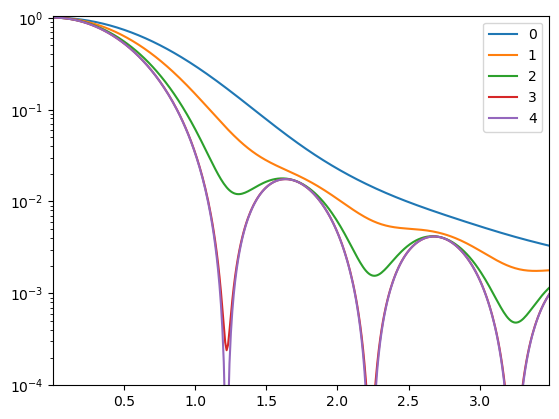

In [175]:
[plt.semilogy(q_stars, E_v_q,label=i) for i,E_v_q in enumerate(E_v_qs)]
plt.ylim(0.0001,1.05)
plt.xlim(q_stars[0],q_stars[-1])
plt.legend()

Beautiful! This is Linse and Södermann Fig 3b